# Import Required Libraries
Import the necessary libraries, including pickle, numpy, torch, and others.

In [1]:
# Import Required Libraries
import pickle
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from typing import List, Set, Tuple
from graph import Graph
import networkx as nx

# Load Data
Load the data from 'data/graphs.dat' using pickle.

In [2]:
# Load Data
with open('data/graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

# Calculate Statistics
Calculate relevant statistics such as max_family_id and create a set of family_ids.

In [3]:
# Calculate Statistics

max_family_id = -1  # Initialize max_family_id
family_ids_set = set()  # Initialize set to store unique family_ids

# Iterate through all graphs to calculate statistics
for graph in graphs:
    parts = graph.get_parts()
    for part in parts:
        family_id = int(part.get_family_id())
        family_ids_set.add(family_id)
        max_family_id = max(family_id, max_family_id)

# Print the calculated statistics
print(max_family_id)
print(len(family_ids_set))

95
88


# Switch to Training Data
Switch to use training data only by loading 'data/train_graphs.dat'.

In [4]:
# Switch to Training Data
train_validation_graphs, test_graphs = train_test_split(graphs, test_size=0.15, random_state=65)

# Generate Features and Targets
Generate features and targets using family_ids instead of part_ids.

In [5]:
# Generate Features and Targets

size = max_family_id + 1

features = []
targets = []

for graph in train_validation_graphs:
    # Feature 1: One-hot encoded graph using family_ids
    family_ids_graph = graph.get_parts()
    family_ids_graph = [int(part.get_family_id()) for part in family_ids_graph]
    feature_graph = torch.zeros(size, dtype=torch.float)
    for family_id in family_ids_graph:
        feature_graph[family_id] += 1

    edges = graph.get_edges()
    for source_node, target_nodes in edges.items():
        source_id = int(source_node.get_part().get_family_id())

        # One-hot encode the source_id with pytorch tensors
        feature_source_id = torch.zeros(size, dtype=torch.float)
        feature_source_id[source_id] = 1

        target = torch.zeros(size, dtype=torch.float)
        for target_node in target_nodes:
            target_id = int(target_node.get_part().get_family_id())
            target[target_id] = 1

        targets.append(target)
        features.append(torch.cat([feature_graph, feature_source_id]))

# Debugging
#torch.set_printoptions(profile="full")
#print(features[0])
#print(targets[0])


# Create the Model
Define and create the FFNModel using PyTorch.

In [6]:
# Create the Model
from ffn import FFNModel


def create_model(input_size, output_size, hidden_sizes=[128, 128], lr=0.00005):
    model = FFNModel(input_size, output_size, hidden_sizes)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

# Example usage:
input_size = size * 2
output_size = size
hidden_sizes = [128, 128]
learning_rate = 0.0005

model, criterion, optimizer = create_model(input_size, output_size, hidden_sizes, learning_rate)

# Prepare Data for Training
Prepare the data for training by splitting it into train, validation, and test sets and creating DataLoaders.

In [7]:
# Prepare Data for Training

# Split data into train, validation, and test sets (60%, 20%, 20%) without library
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.82, random_state=21, shuffle=False)


# Create the DataLoader
train_data = TensorDataset(torch.stack(X_train), torch.stack(y_train))
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)

test_data = TensorDataset(torch.stack(X_test), torch.stack(y_test))
test_loader = DataLoader(test_data, batch_size=1024, shuffle=True)

# Training Process
Train the model using the training data and evaluate it using the test data.

Epoch 1/100, Loss: 0.45679887731013624
Test Loss: 0.09084001584694935
Epoch 2/100, Loss: 0.07273767451787817
Test Loss: 0.06711604790045665
Epoch 3/100, Loss: 0.06595744436670994
Test Loss: 0.06386676946511635
Epoch 4/100, Loss: 0.06235401948978161
Test Loss: 0.05942680686712265
Epoch 5/100, Loss: 0.057303869326053
Test Loss: 0.054167951528842635
Epoch 6/100, Loss: 0.05260888275144429
Test Loss: 0.05004500368466744
Epoch 7/100, Loss: 0.04847441665057478
Test Loss: 0.04583183045570667
Epoch 8/100, Loss: 0.043905054765014814
Test Loss: 0.041039409259190925
Epoch 9/100, Loss: 0.03919902861375233
Test Loss: 0.036611154388922915
Epoch 10/100, Loss: 0.035121939626747166
Test Loss: 0.0329825091533936
Epoch 11/100, Loss: 0.03171092955845183
Test Loss: 0.029855002290927447
Epoch 12/100, Loss: 0.02872594105529374
Test Loss: 0.02701623995716755
Epoch 13/100, Loss: 0.02597308897509657
Test Loss: 0.024328847487385456
Epoch 14/100, Loss: 0.023364008307970804
Test Loss: 0.021836041401212033
Epoch 15/

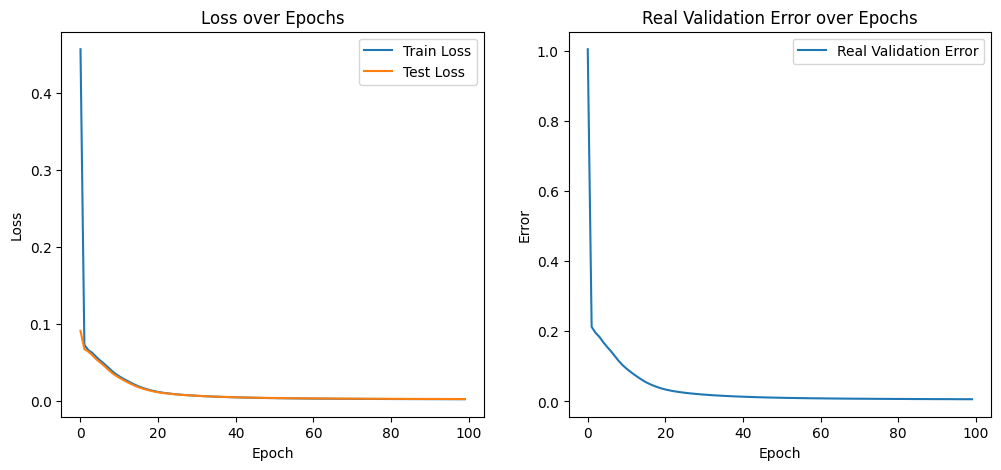

In [8]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, debug=False):
    train_losses = []
    test_losses = []
    real_validation_errors = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        if debug:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

        # Evaluation
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()
        test_losses.append(validation_loss / len(test_loader))
        if debug:
            print(f'Test Loss: {validation_loss/len(test_loader)}')

        # Calculate real validation error
        real_validation_error = running_loss / len(train_loader) + abs(running_loss / len(train_loader) + validation_loss / len(test_loader))
        real_validation_errors.append(real_validation_error)

    return train_losses, test_losses, real_validation_errors

# Example usage:
train_losses, test_losses, real_validation_errors = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, debug=True)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(real_validation_errors, label='Real Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Real Validation Error over Epochs')
plt.legend()

plt.show()

In [12]:
import random

def random_hyperparameter_search(num_trials=10):
    best_model = None
    best_loss = float('inf')
    best_params = None

    for trial in range(num_trials):


        # Randomly select hyperparameters

        params = {
            'hidden_sizes': [random.choice([32, 64, 128, 256]), random.choice([32, 64, 128, 256, 512])],
            'learning_rate': random.choice([0.1, 0.001, 0.0001, 0.00005, 0.00001]),
            'batch_size': random.choice([32, 64, 128, 256]),
            'num_epochs': random.choice([50, 100, 150, 200, 250])
        }

        # Create the model with the selected hyperparameters
        model, criterion, optimizer = create_model(input_size, output_size, hidden_sizes=params['hidden_sizes'], lr=params['learning_rate'])

        # Create DataLoaders with the selected batch size
        train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(test_data, batch_size=params['batch_size'], shuffle=True)

        # Train the model
        train_losses, test_losses, real_validation_errors = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=params['num_epochs'])   

        # Evaluate the model
        final_loss = test_losses[-1]
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_params = params

        print(f"Trial {trial+1}/{num_trials} - Loss: {final_loss}, Params: {params}")

    return best_model, best_params

# Example usage:
best_model, best_params = random_hyperparameter_search(num_trials=20)
print(f"Best Params: {best_params}")

Trial 1/20 - Loss: 0.0051025502799151865, Params: {'hidden_sizes': [128, 256], 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 200}
Trial 2/20 - Loss: 0.020692075146179573, Params: {'hidden_sizes': [64, 32], 'learning_rate': 1e-05, 'batch_size': 256, 'num_epochs': 250}
Trial 3/20 - Loss: 0.0019422582802324578, Params: {'hidden_sizes': [256, 32], 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 50}
Trial 4/20 - Loss: 1.6150125317713793, Params: {'hidden_sizes': [128, 512], 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 100}
Trial 5/20 - Loss: 0.0020912496427841045, Params: {'hidden_sizes': [128, 256], 'learning_rate': 5e-05, 'batch_size': 128, 'num_epochs': 200}
Trial 6/20 - Loss: 0.001876824405888899, Params: {'hidden_sizes': [128, 64], 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 250}
Trial 7/20 - Loss: 0.04485388553025676, Params: {'hidden_sizes': [32, 64], 'learning_rate': 0.1, 'batch_size': 256, 'num_epochs': 200}
Trial 8/20 - Loss: 0.001777909984

In [9]:
from prediction_classes.family_predictor import FamilyPredictor
from evaluation import evaluate

def get_accuray(model, graphs):
    predictor = FamilyPredictor()

    predictor.model = model
    accuracy = evaluate(predictor, [[graph.get_parts(), graph] for graph in graphs])

    return accuracy

## Print Graph Accuracy
print(f'Accuracy Test: {get_accuray(model, test_graphs)}')



Accuracy Test: {'edge_accuracy': 96.4713671587232, 'exact_match': 61.40979689366786}


# Save the Model
Save the trained model to 'edge_prediction_model.pth'.

In [10]:
# Save the full model
torch.save(model, 'edge_prediction_models/family_edge_prediction_model.pth')